In [5]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [33]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pickle
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows

# Data Preprocessing

In [34]:
df = pd.read_csv('../data_v02/dataset.csv')
#df.IGBP = df.IGBP.astype('category')
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,LE_PM_min,LE_PM_max,LE_PM_std,doy,year,lat,lon,IGBP,LE,site
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,-8091.0,14466.0,8934.811384,144,2003,46.7305,-91.2329,DBF,19.2224,FLX_US-Wi1
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,-8091.0,14466.0,8927.863731,145,2003,46.7305,-91.2329,DBF,24.2024,FLX_US-Wi1
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,-8091.0,14466.0,8938.041316,146,2003,46.7305,-91.2329,DBF,19.4017,FLX_US-Wi1
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,-8091.0,14466.0,8933.245569,147,2003,46.7305,-91.2329,DBF,23.7468,FLX_US-Wi1
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,-8091.0,14466.0,8943.574997,148,2003,46.7305,-91.2329,DBF,42.2603,FLX_US-Wi1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,-16360.0,10298.0,9260.157236,254,2003,46.6347,-91.0987,DBF,55.7628,AMF_US-Wi3
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,-16360.0,10298.0,9266.910797,256,2003,46.6347,-91.0987,DBF,31.6040,AMF_US-Wi3
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,-16360.0,10298.0,9262.322928,257,2003,46.6347,-91.0987,DBF,54.2463,AMF_US-Wi3
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,-16360.0,10348.0,9277.527589,258,2003,46.6347,-91.0987,DBF,44.2428,AMF_US-Wi3


In [35]:
summary_df = pd.DataFrame(columns=['lightgbm_classic', 'lightgbm_site_year',
                                  'xgboost_classic', 'xgboost_site_year',
                                  'rf_classic', 'rf_site_year',
                                  'catboost_classic', 'catboost_site_year',
                                  'ann_classic', 'ann_site_year'])

In [36]:
'''Classical Train/Test'''
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df.drop(['LE', 'site'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

In [37]:
'''Site-year split'''
df['site_year'] = df['site'].astype(str) + '_' + df['year'].astype(str)

site_year_igbp = df.groupby('site_year')['IGBP'].agg(lambda x: x.mode()[0]).reset_index()#for each site-year, get the dominant IGBP class

train_site_years, test_site_years = train_test_split(
    site_year_igbp['site_year'],
    test_size=0.3,
    stratify=site_year_igbp['IGBP'],
    random_state=42
)

train_df = df[df['site_year'].isin(train_site_years)]
test_df = df[df['site_year'].isin(test_site_years)]
X_train_2, y_train_2 = train_df.drop(['LE', 'site', 'site_year'], axis=1), train_df['LE']
X_test_2, y_test_2 = test_df.drop(['LE', 'site', 'site_year'], axis=1), test_df['LE']

In [38]:
data = {'classic': [X_train_1, X_test_1, y_train_1, y_test_1],
        'site_year': [X_train_2, X_test_2, y_train_2, y_test_2]}

In [39]:
class Dataset():
    def __init__(self, X, Y, x_scaler=None, y_scaler=None, fit_scaler=False):
        if fit_scaler:
            self.x_scaler = MinMaxScaler()  
            self.y_scaler = MinMaxScaler()  
            X = self.x_scaler.fit_transform(X) 
            Y = self.y_scaler.fit_transform(Y.reshape(-1, 1)) 
        elif x_scaler is not None:
            X = x_scaler.transform(X)  
            Y = y_scaler.transform(Y.reshape(-1, 1)) 
            
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32).to(device)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [40]:
class ANN(nn.Module):
    def __init__(self, INPUT_SIZE, n1, n2, dropout=0.3):
        super().__init__()
	
        self.net = nn.Sequential()
        self.net.add_module('Linear_1', nn.Linear(INPUT_SIZE, n1))
        self.net.add_module('ReLU_1', nn.LeakyReLU()) #Sigmoid
        self.net.add_module('Drop_1', nn.Dropout(dropout))
        
        self.net.add_module('Linear_2', torch.nn.Linear(n1, n2))
        self.net.add_module('Norm', nn.BatchNorm1d(n2))
        self.net.add_module('ReLU_2', nn.LeakyReLU())
        self.net.add_module('Drop_2', nn.Dropout(dropout))
        self.net.add_module('Linear_3',torch.nn.Linear(n2, 1))

    def forward(self, y):
        return self.net(y)

In [42]:
summary_df = {}

In [66]:
for key in list(data.keys()):
    '''LightGBM'''
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    train_data = lgb.Dataset(X_train, label=y_train.astype(float), categorical_feature='IGBP')
    test_data = lgb.Dataset(X_test, label=y_test.astype(float), reference=train_data, categorical_feature='IGBP')

    lgbm = lgb.Booster(model_file=f'../models/lightgbm_model_{key}.txt')

    y_pred_lgb = lgbm.predict(X_test)
    summary_df[f'lightgbm_{key}'] = y_pred_lgb
    
    '''XGBoost'''
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    best_params = {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 0.6, 'n_estimators': 100, 
               'colsample_bytree': 0.9, 'subsample': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 
               'verbosity': 0, 'tree_method': 'gpu_hist', 'n_jobs': -1}

    xgboost =  xgb.XGBRegressor(**best_params, device="cuda")
    xgboost.load_model(f'../models/xgboost_model_{key}.json')
    y_pred = xgboost.predict(X_test)
    summary_df[f'xgboost_{key}'] = y_pred
    
    '''RF'''
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')

    one_hot = pd.get_dummies(X_train.IGBP)
    X_train = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    one_hot = pd.get_dummies(X_test.IGBP)
    X_test = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    if 'OSH' not in X_test.columns:
        X_test.insert(80, column='OSH', value=[0] * len(X_test))
    
    best_params = {'max_depth': 22, 'n_estimators': 100, 'random_state': 42, 'n_jobs': -1}
    model =  RandomForestRegressor(**best_params)
    with open(f"../models/rf_model_{key}.pkl", "rb") as f:
        model = pickle.load(f)
        
    y_pred = model.predict(X_test)
    summary_df[f'rf_{key}'] = y_pred
    
    '''CatBoost'''
    best_params = {'depth': 16,  'iterations': 2000,
                   'bootstrap_type': 'Poisson', 
                   'l2_leaf_reg': 0, 
                   'loss_function': 'RMSE', 'task_type': 'GPU', 
                   'verbose': 0, 'random_seed': 42}
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    train_pool = Pool(X_train, y_train, cat_features=['IGBP'])
    test_pool = Pool(X_test, y_test, cat_features=['IGBP'])

    model = CatBoostRegressor(**best_params)
    model.load_model(f"../models/catboost_model_{key}.cbm")
    y_pred = model.predict(X_test)
    summary_df[f'catboost_{key}'] = y_pred
    
    '''ANN'''
    num_epoch = 2000
    feature_num = 82
    n1 = 400
    n2 = 100
    dropout=0.3
    BATCH_SIZE = 512
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    model = ANN(feature_num, n1,n2, dropout).to(device).to(torch.float32)
    
    X_train, X_test, y_train, y_test = data[key][0], data[key][1], data[key][2], data[key][3]
    X_train['IGBP'] = X_train.IGBP.astype('category')
    X_test['IGBP'] = X_test.IGBP.astype('category')
    
    one_hot = pd.get_dummies(X_train.IGBP)
    X_train_ann = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    one_hot = pd.get_dummies(X_test.IGBP)
    X_test_ann = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
    X_test_ann['OSH'] = [0] * len(X_test)
    
    train_dataset = Dataset(X_train_ann, y_train.values, fit_scaler=True)
    x_scaler = train_dataset.x_scaler 
    y_scaler = train_dataset.y_scaler 
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False)
    test_loader = DataLoader(Dataset(X_test_ann.values, y_test.values,
                                     x_scaler=x_scaler, y_scaler=y_scaler), batch_size=BATCH_SIZE, drop_last=False)
    
    model.load_state_dict(torch.load(f'../models/ANN_{key}.pth'))
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(torch.float32), y.to(torch.float32)
            preds = model(x)
            preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
            y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
            test_preds.append(torch.tensor(preds))
            test_true.append(torch.tensor(y_scaled))

    test_preds = torch.cat(test_preds).squeeze()
    test_true = torch.cat(test_true).squeeze()
    
    summary_df[f'ann_{key}'] = test_preds.numpy()
    
    summary_df[f'true_{key}'] = test_true.numpy()

In [68]:
summary_df

{'lightgbm_classic': array([  5.86818639,   9.77649065,  53.5978429 , ..., 112.80069032,
         76.82122548,  22.11795507], shape=(30010,)),
 'xgboost_classic': array([  6.6447163,   7.0537543,  53.395294 , ..., 109.3289   ,
         77.779015 ,  23.048159 ], shape=(30010,), dtype=float32),
 'rf_classic': array([  7.07377773,   8.6864442 ,  52.8609795 , ..., 100.450059  ,
         79.73150843,  25.8356105 ], shape=(30010,)),
 'ann_classic': array([  7.48855676,   7.83994885,  54.04713448, ..., 101.24156798,
         68.6279305 ,  22.30420968], shape=(30010,)),
 'lightgbm_site_year': array([30.14733767, 29.68159073, 48.51426308, ..., 12.26465824,
         4.15775651,  4.01929552], shape=(30050,)),
 'xgboost_site_year': array([44.17916  , 34.899933 , 51.20126  , ..., 11.8226795,  4.5801253,
         4.2046466], shape=(30050,), dtype=float32),
 'rf_site_year': array([41.0462893 , 26.94711619, 53.97245073, ..., 12.15478564,
         4.77867556,  4.27626757], shape=(30050,)),
 'ann_site_y

# Visuals

In [69]:
plot_data = []
for key in list(data.keys()):
    df = pd.DataFrame({
        'True': summary_df[f'true_{key}'],
        'XGBoost': summary_df[f'xgboost_{key}'],
        'Light GBM': summary_df[f'lightgbm_{key}'],
        'Random Forest': summary_df[f'rf_{key}'],
        'CatBoost': summary_df[f'catboost_{key}'],
        'Artificial Neural Network': summary_df[f'ann_{key}'],
    })
    df_long = df.melt(id_vars='True', var_name='Model', value_name='Prediction')
    df_long['Key'] = key
    plot_data.append(df_long)

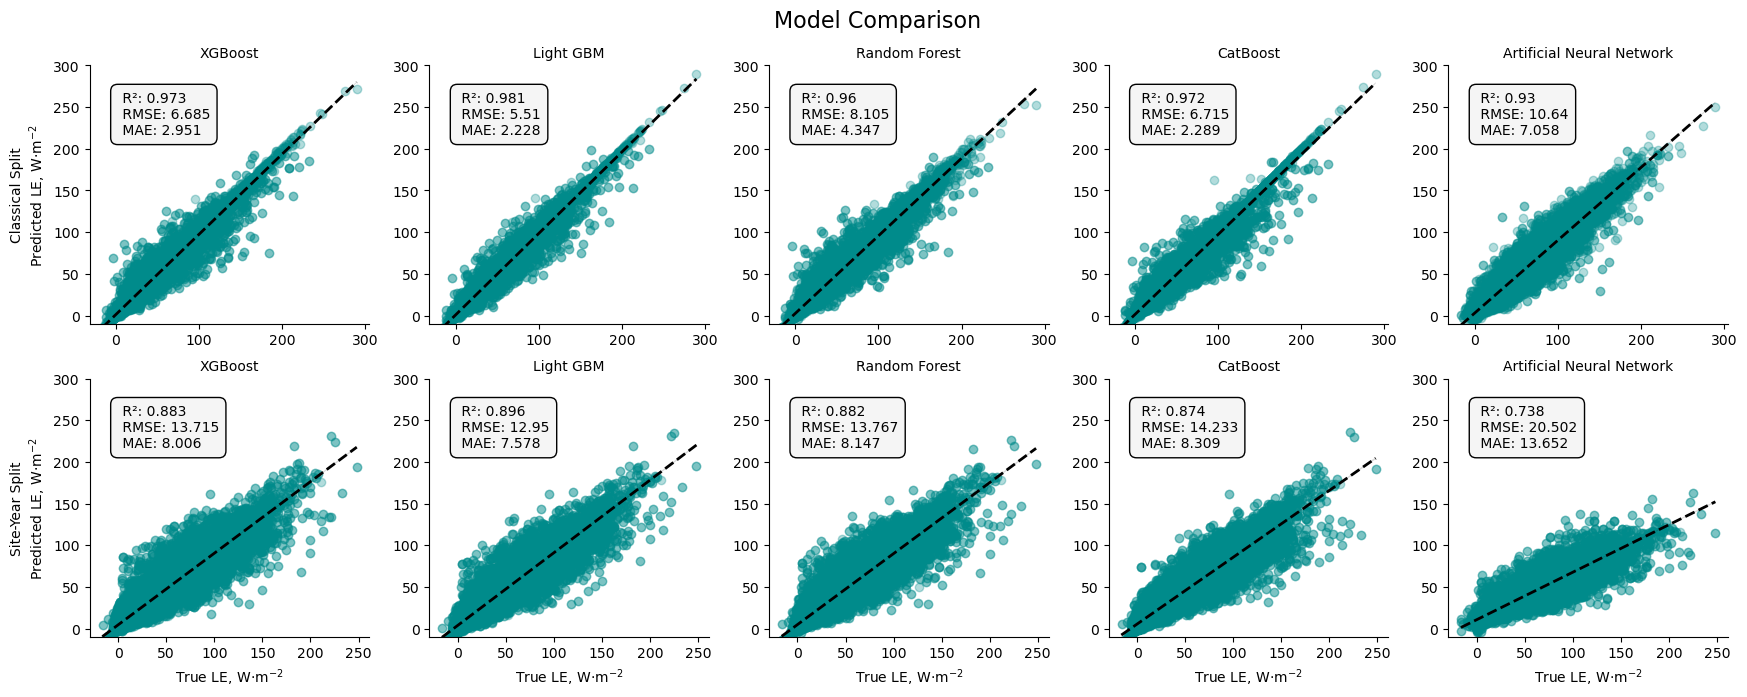

In [79]:
df_all = pd.concat(plot_data, ignore_index=True)

# Create the FacetGrid: row = key, col = model
g = sns.FacetGrid(df_all, col="Model", row="Key", height=3.5, sharex=False, sharey=False)

# Plot scatter with regression line
g.map_dataframe(
    sns.regplot,
    x='True', y='Prediction',
    scatter_kws={'alpha': 0.3, 'color': 'darkcyan'},
    line_kws={'color': 'black', 'ls': '--', 'lw': 2}
)

# Customize axes and annotations
for (row_key, col_model), ax in g.axes_dict.items():
    subset = df_all[(df_all['Key'] == row_key) & (df_all['Model'] == col_model)]
    r2 = round(r2_score(subset['True'], subset['Prediction']), 3)
    rmse = round(mean_squared_error(subset['True'], subset['Prediction'])**0.5, 3)
    mae = round(mean_absolute_error(subset['True'], subset['Prediction']), 3)
    info_text = f" R\u00b2: {r2} \n RMSE: {rmse}\n MAE: {mae}"
    ax.text(0.1, 0.9, info_text, transform=ax.transAxes,
            ha='left', va='top', fontsize=10,
            bbox=dict(facecolor='whitesmoke', edgecolor='black', boxstyle='round,pad=0.5'))
    
    ax.set_ylim(-10,300)
    if col_model != 'XGBoost':
        ax.set_ylabel('')
    else:
        if row_key=='site_year':
            ax.set_ylabel('Site-Year Split\nPredicted LE, W\u22C5m$^{-2}$')
        else:
            ax.set_ylabel('Classical Split\nPredicted LE, W\u22C5m$^{-2}$')

    if row_key != list(data.keys())[-1]:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('True LE, W\u22C5m$^{-2}$')

g.set_titles(template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Model Comparison", fontsize=16)
g.fig.subplots_adjust(left=0.05)
plt.savefig('../fig/model_comparison_scatter.png')
plt.show()

# Validation

In [8]:
mod = np.load('../data_v02/validation/MOD_features.npy', allow_pickle=True)
mod_idxs = mod[:,-1].astype(int)
mod = mod[:,:-1] # drop last (idx)
era5 = np.load('../data_v02/validation/ERA5_features.npy', allow_pickle=True)
era5_idxs = era5[:,0,-1].astype(int)
era5 = era5[:,:,:-1] # drop last (idx)

fluxes = pd.read_csv('../data_v02/validation/validation_dataset.csv')
#fluxes = fluxes[fluxes['LE_F_MDS_QC']>=0.75]
keep_idxs = [idx for idx in fluxes.index.tolist() if (idx in era5_idxs) and (idx in mod_idxs)]
fluxes = fluxes.loc[keep_idxs,:]
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y-%m-%d')
#targets = fluxes.LE_F_MDS.values

fluxes

,TIMESTAMP,ETos_daily_in,ETrs_daily_in,site,lat,lon
0,2019-01-01,5.04875,6.49125,Becker,45.34399,-93.85014
1,2019-01-02,9.37625,13.70375,Becker,45.34399,-93.85014
2,2019-01-03,16.58875,23.80125,Becker,45.34399,-93.85014
3,2019-01-04,17.31000,22.35875,Becker,45.34399,-93.85014
4,2019-01-05,18.03125,25.96500,Becker,45.34399,-93.85014
...,...,...,...,...,...,...
18278,2022-12-27,9.37625,12.98250,Westport,45.71509,-95.17179
18279,2022-12-28,6.49125,7.21250,Westport,45.71509,-95.17179
18280,2022-12-29,2.88500,2.88500,Westport,45.71509,-95.17179
18281,2022-12-30,7.93375,9.37625,Westport,45.71509,-95.17179


In [34]:
era5_idxs = pd.Series(list(era5_idxs))
era5_idxs.index = np.arange(len(era5_idxs))
valid_feature_indices = era5_idxs[era5_idxs.isin(fluxes.index)].index.values
era5_features = era5[valid_feature_indices]

mod_idxs = pd.Series(list(mod_idxs))
mod_idxs.index = np.arange(len(mod_idxs))
valid_feature_indices = mod_idxs[mod_idxs.isin(fluxes.index)].index.values
mod_features = mod[valid_feature_indices]
#mod_features = mod_features[:,:,:-1]#Dropping Coarse_Resolution_Internal_CM

NDVI = (mod_features[:,1] - mod_features[:,0])/(mod_features[:,1] + mod_features[:,0])
EVI = (mod_features[:,1] - mod_features[:,0])/(mod_features[:,1] + 6*mod_features[:,0] - 7.5*mod_features[:,2] + 1)
GNDVI = (mod_features[:,1] - mod_features[:,3])/(mod_features[:,1] + mod_features[:,3])
SAVI = (mod_features[:,1] - mod_features[:,0])/(mod_features[:,1] + mod_features[:,0] + 0.5)*1.5
ARVI = (mod_features[:,1] + mod_features[:,2] - 2*mod_features[:,0])/(mod_features[:,1] + mod_features[:,2] + 2*mod_features[:,0])

#pm_flux = penman_monteith(fluxes, fluxes.index, fluxes, mode='ground').values 
pm_era = penman_monteith(era5_features, fluxes.index, fluxes, mode='era5') 

features = np.concatenate([era5_features[:,-1,:], mod_features, pm_era[:, -1].reshape(-1,1),
                           NDVI[:,np.newaxis], EVI[:,np.newaxis], GNDVI[:,np.newaxis],
                           SAVI[:,np.newaxis], ARVI[:,np.newaxis]], axis=1)

era_names = list(np.loadtxt('../data_v02/ERA5_features_names.txt', dtype=str))[:-1]
mod_names = [
          'SensorZenith', 'SensorAzimuth', 'SolarZenith', 'SolarAzimuth',
         'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04',
         'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'Clouds']


In [36]:
df = pd.DataFrame(data=features, columns=era_names + mod_names + ['LE_PM'] + ['NDVI', 'EVI', "GNDVI", 'SAVI', 'ARVI']) 

In [42]:
ts=np.concatenate([era5_features, pm_era[:, :, np.newaxis]], axis=2)

In [43]:
for idx, col in enumerate(era_names+['LE_PM']): # TS are only for the ERA5-derived variables
    if col in ['surface_net_solar_radiation_sum','total_evaporation_sum','total_precipitation_sum',]:
        ewm = pd.DataFrame(ts[:,:,idx]).T.rolling(window=30).sum().iloc[[-1]].values
        df[col+'_rol_30'] = ewm.T
        ewm_7 = pd.DataFrame(ts[:,:,idx]).T.rolling(window=7).sum().iloc[[-1]].values
        df[col+'_rol_7'] = ewm_7.T
    else:
      ewm = pd.DataFrame(ts[:,:,idx]).T.rolling(window=30, min_periods=1).mean().iloc[[-1]].values#.ewm(span=3, adjust=False).mean()
      df[col+'_rol_30'] = ewm.T
      ewm_7 = pd.DataFrame(ts[:,:,idx]).T.rolling(window=7, min_periods=1).mean().iloc[[-1]].values#.ewm(span=3, adjust=False).mean()
      df[col+'_rol_7'] = ewm_7.T
    Min = pd.DataFrame(ts[:,:,idx]).T.min(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_min'] = Min
    Max = pd.DataFrame(ts[:,:,idx]).T.max(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_max'] = Max
    std = pd.DataFrame(ts[:,:,idx]).T.std(axis=0).values#.ewm(span=3, adjust=False).mean()
    df[col+'_std'] = std
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,total_precipitation_sum_rol_30,total_precipitation_sum_rol_7,total_precipitation_sum_min,total_precipitation_sum_max,total_precipitation_sum_std,LE_PM_rol_30,LE_PM_rol_7,LE_PM_min,LE_PM_max,LE_PM_std
0,255.630463,251.406054,0.756690,-2.618446,3127300.0,-0.000249,99223.808268,2.005696e-05,2512.0,-7676.0,...,0.042546,0.039740,0.0,0.028442,0.005296,88.206037,38.799405,15.184800,169.008927,39.237387
1,255.239458,251.471895,1.201426,2.460250,2803272.0,-0.000056,98180.523926,6.901026e-05,5245.0,9507.0,...,0.042565,0.039061,0.0,0.028442,0.005296,86.324058,33.646021,15.184800,169.008927,40.612371
2,268.915032,266.482390,2.210740,2.014928,2741450.0,-0.000078,97351.725098,8.776784e-06,557.0,-8240.0,...,0.042414,0.010628,0.0,0.028442,0.005297,86.029571,40.790961,15.184800,169.008927,40.736403
3,272.659852,270.606938,2.405130,0.945816,3439466.0,0.000022,97093.597493,8.523463e-07,5604.0,-7032.0,...,0.042159,0.003469,0.0,0.028442,0.005299,86.451802,49.253091,15.184800,169.008927,40.810581
4,273.813017,271.365071,2.736542,-0.429501,3687898.0,0.000018,97348.727214,0.000000e+00,1524.0,10113.0,...,0.042136,0.003463,0.0,0.028442,0.005300,87.465515,59.302280,15.184800,169.008927,41.049762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17911,260.618490,257.382262,-0.169287,4.541701,1592956.0,-0.000115,96043.470703,8.523463e-07,2805.0,9967.0,...,0.055704,0.009413,0.0,0.013911,0.003480,53.978021,16.137366,8.044659,133.810651,39.436997
17912,271.758979,269.946012,-1.900719,3.586609,1609196.0,-0.000041,94619.562663,2.378225e-05,3581.0,-7404.0,...,0.055727,0.005480,0.0,0.013911,0.003479,50.973591,21.227804,8.044659,123.543618,36.466836
17913,270.447507,269.547889,1.825726,-1.061621,1182552.0,-0.000147,95297.477702,7.933378e-05,4671.0,9567.0,...,0.055443,0.002958,0.0,0.013911,0.003484,49.660166,24.185260,8.044659,123.543618,36.359187
17914,261.732502,259.375592,2.194625,-0.525342,2489184.0,-0.000095,96381.266764,8.899271e-05,1342.0,-7886.0,...,0.055228,0.002926,0.0,0.013911,0.003488,48.407165,28.569316,8.044659,123.543618,35.908129


In [67]:
df['doy'] = fluxes['TIMESTAMP'].reset_index(drop=True).dt.dayofyear
df['lat'] = fluxes.lat.values
df['lon'] = fluxes.lon.values
#df['IGBP'] = fluxes.IGBP.values
#df['IGBP'] = df['IGBP'].astype('category')
df['LEos'] = fluxes.ETos_daily_in.values
df['LErs'] = fluxes.ETrs_daily_in.values
df = df.dropna()
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,LE_PM_rol_30,LE_PM_rol_7,LE_PM_min,LE_PM_max,LE_PM_std,doy,lat,lon,LEos,LErs
0,255.630463,251.406054,0.756690,-2.618446,3127300.0,-0.000249,99223.808268,2.005696e-05,2512.0,-7676.0,...,88.206037,38.799405,15.184800,169.008927,39.237387,1,45.34399,-93.85014,5.04875,6.49125
1,255.239458,251.471895,1.201426,2.460250,2803272.0,-0.000056,98180.523926,6.901026e-05,5245.0,9507.0,...,86.324058,33.646021,15.184800,169.008927,40.612371,2,45.34399,-93.85014,9.37625,13.70375
2,268.915032,266.482390,2.210740,2.014928,2741450.0,-0.000078,97351.725098,8.776784e-06,557.0,-8240.0,...,86.029571,40.790961,15.184800,169.008927,40.736403,3,45.34399,-93.85014,16.58875,23.80125
3,272.659852,270.606938,2.405130,0.945816,3439466.0,0.000022,97093.597493,8.523463e-07,5604.0,-7032.0,...,86.451802,49.253091,15.184800,169.008927,40.810581,4,45.34399,-93.85014,17.31000,22.35875
4,273.813017,271.365071,2.736542,-0.429501,3687898.0,0.000018,97348.727214,0.000000e+00,1524.0,10113.0,...,87.465515,59.302280,15.184800,169.008927,41.049762,5,45.34399,-93.85014,18.03125,25.96500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17911,260.618490,257.382262,-0.169287,4.541701,1592956.0,-0.000115,96043.470703,8.523463e-07,2805.0,9967.0,...,53.978021,16.137366,8.044659,133.810651,39.436997,361,45.71509,-95.17179,9.37625,12.98250
17912,271.758979,269.946012,-1.900719,3.586609,1609196.0,-0.000041,94619.562663,2.378225e-05,3581.0,-7404.0,...,50.973591,21.227804,8.044659,123.543618,36.466836,362,45.71509,-95.17179,6.49125,7.21250
17913,270.447507,269.547889,1.825726,-1.061621,1182552.0,-0.000147,95297.477702,7.933378e-05,4671.0,9567.0,...,49.660166,24.185260,8.044659,123.543618,36.359187,363,45.71509,-95.17179,2.88500,2.88500
17914,261.732502,259.375592,2.194625,-0.525342,2489184.0,-0.000095,96381.266764,8.899271e-05,1342.0,-7886.0,...,48.407165,28.569316,8.044659,123.543618,35.908129,364,45.71509,-95.17179,7.93375,9.37625


In [68]:
colors = ['brown', 'darkcyan']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

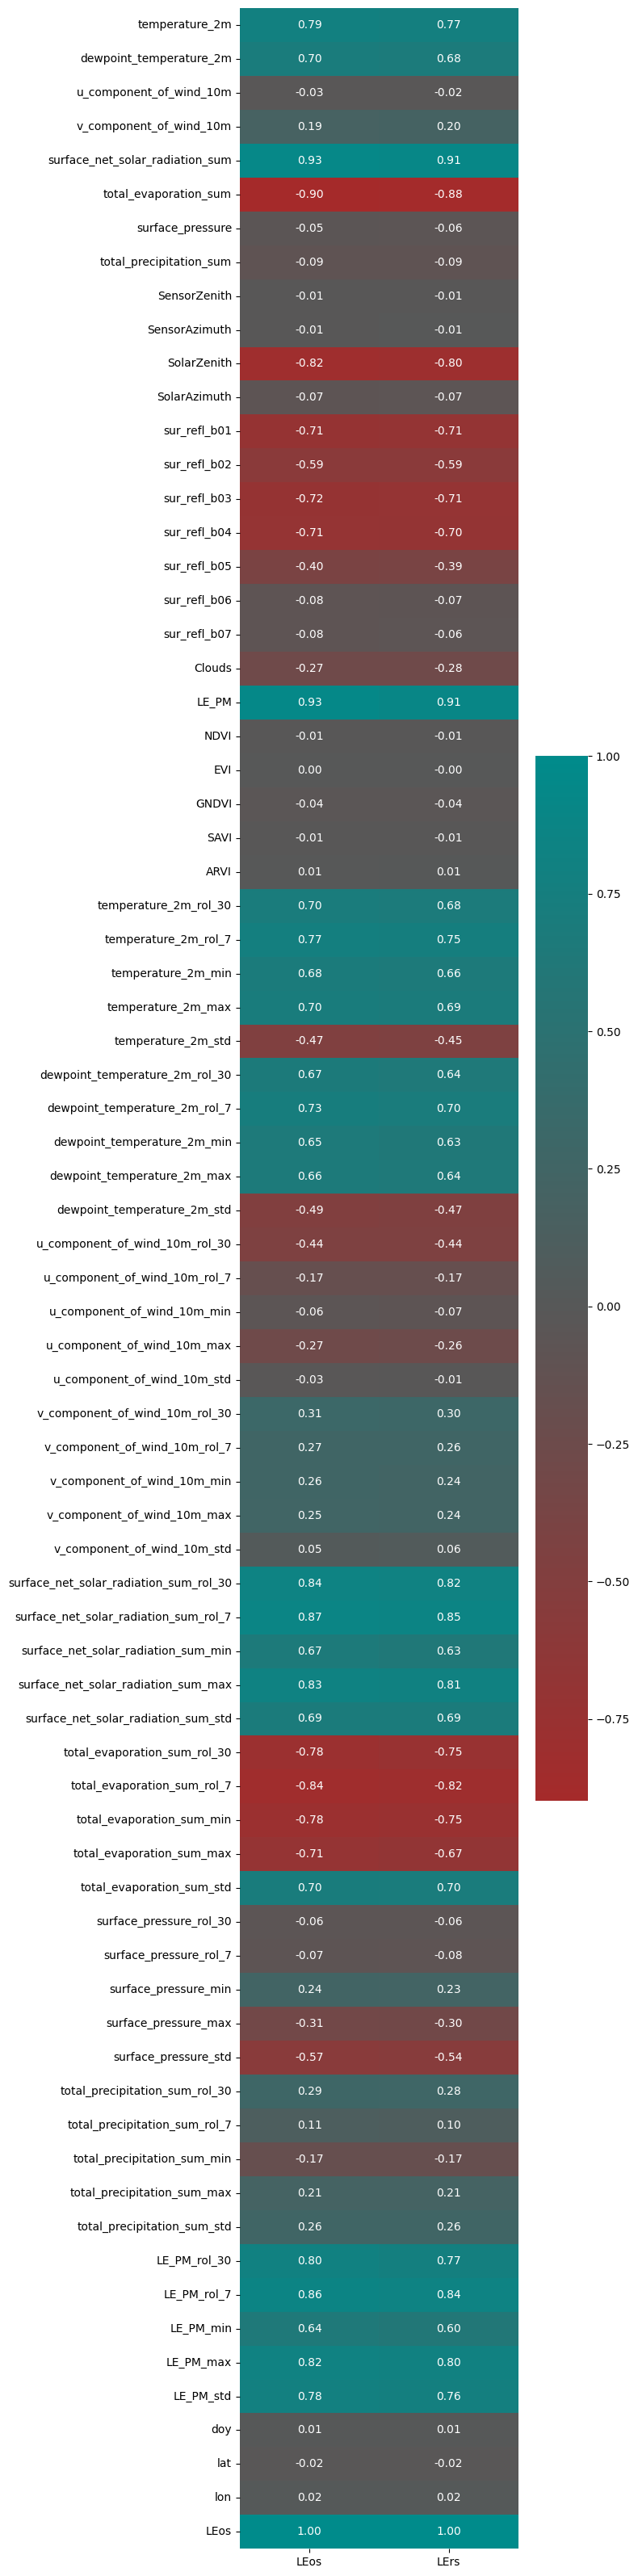

In [71]:
correlation_matrix = df.corr()[["LEos", "LErs"]].iloc[:-1]#.drop('IGBP', axis=1)

plt.figure(figsize=(8, 32))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, cbar=True, fmt=".2f")
plt.tight_layout()
#plt.savefig('./fig/targets_heatmap_ground.png')
plt.show()